# Dataset Download

We'll use the Kaggle's dataset Brain tumor multimodal image (CT & MRI)

https://www.kaggle.com/api/v1/datasets/download/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

In [5]:
# ! curl -L -o raw_data/brain-tumor-multimodal-image-ct-and-mri.zip\ https://www.kaggle.com/api/v1/datasets/download/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

In [ ]:
! ls -l raw_data/brain*

In [ ]:
# ! unzip raw_data/brain-tumor-multimodal-image-ct-and-mri.zip -d raw_data/

# Data Preparation

Lets get to know our dataset, first of all, lets see how many files, do we have an what is the folder structure

In [ ]:
! tree -L 3 raw_data/Dataset

The output is too long as we have 9260 files, so i'll create a inventory file including all file names and location, and then I'll make a summary of the distribution. (I'll only post here the resulting summary, to avoid unproductive logs)

In [3]:
! ! tree -L 4 raw_data/Dataset -o inventory.txt

At this point we have all the images in our environment, here's the file distribution

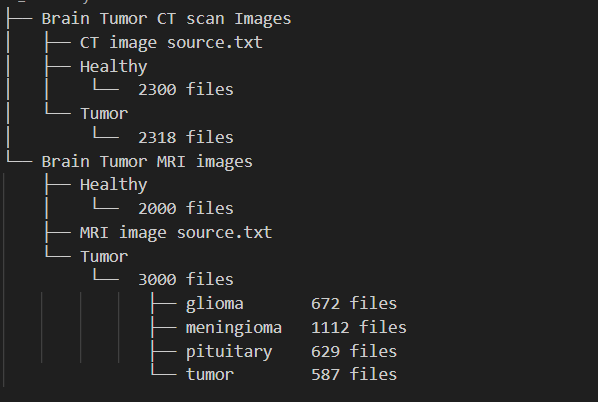

I have a decision to make here, I could identify the presence of a tumor for each method, adding up to 4 classes (CT healthy/tumor + MRI healthy/tumor), but for learning purposes I'll use also the tumor types available at MRI.

This may create an imbalance problem, but lets see the results.

So, I'll proceed with the split

In [ ]:
! tree -fL 2 Dataset/

In [2]:
!find Dataset -type d -exec sh -c 'echo "{}: $(find "{}" -type f | wc -l) files"' \;

Dataset: 17793 files
Dataset/test: 1445 files
Dataset/test/ct_tumor: 348 files
Dataset/test/mri_glioma: 101 files
Dataset/test/ct_healthy: 345 files
Dataset/test/mri_pituitary: 95 files
Dataset/test/mri_healthy: 300 files
Dataset/test/mri_meningioma: 167 files
Dataset/test/mri_tumor: 89 files
Dataset/full_train: 8175 files
Dataset/full_train/ct_tumor: 1970 files
Dataset/full_train/mri_glioma: 571 files
Dataset/full_train/ct_healthy: 1955 files
Dataset/full_train/mri_pituitary: 535 files
Dataset/full_train/mri_healthy: 1700 files
Dataset/full_train/mri_meningioma: 945 files
Dataset/full_train/mri_tumor: 499 files
Dataset/val: 1443 files
Dataset/val/ct_tumor: 348 files
Dataset/val/mri_glioma: 101 files
Dataset/val/ct_healthy: 345 files
Dataset/val/mri_pituitary: 94 files
Dataset/val/mri_healthy: 300 files
Dataset/val/mri_meningioma: 167 files
Dataset/val/mri_tumor: 88 files
Dataset/train: 6730 files
Dataset/train/ct_tumor: 1622 files
Dataset/train/mri_glioma: 470 files
Dataset/train/ct_h

# EDA - Exploratory Data Analysis

## Explore images

We will explore the dataset in greater detail to better understand it and try to identify general or structural patterns inherent to the data, enabling us to make better decisions in the model design process. We'll begin showing some random examples

Folder: Dataset/train/ct_tumor


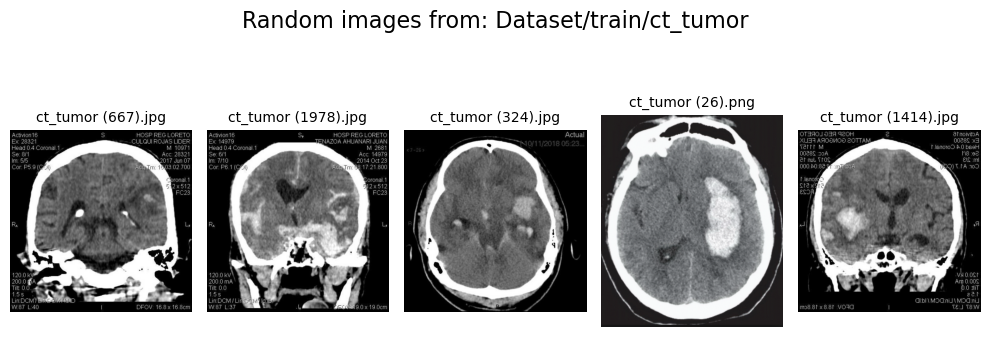

Folder: Dataset/train/mri_glioma


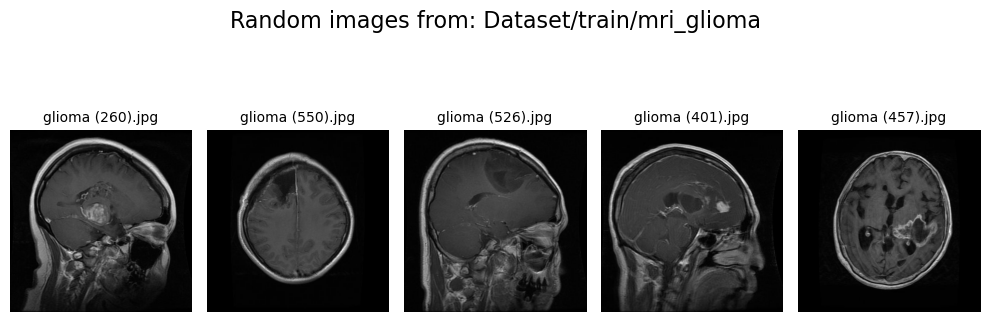

Folder: Dataset/train/ct_healthy


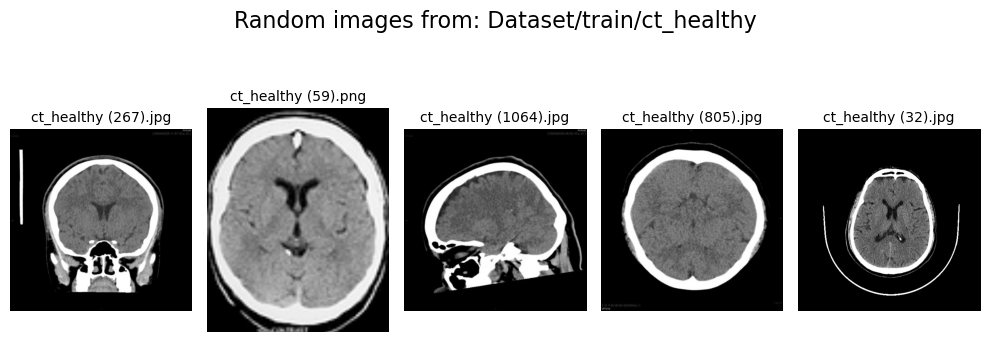

Folder: Dataset/train/mri_pituitary


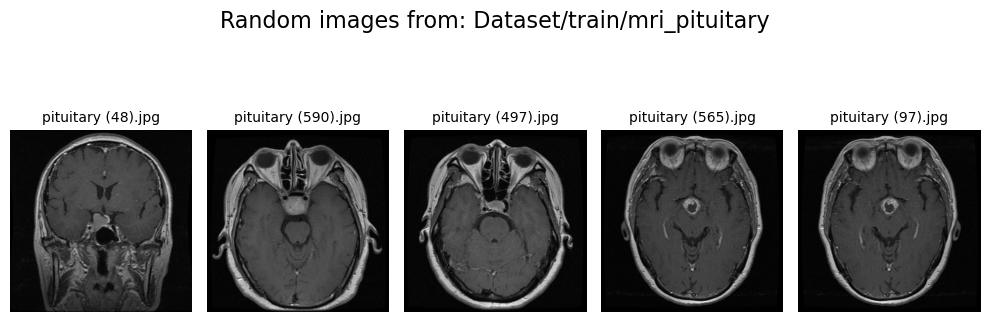

Folder: Dataset/train/mri_healthy


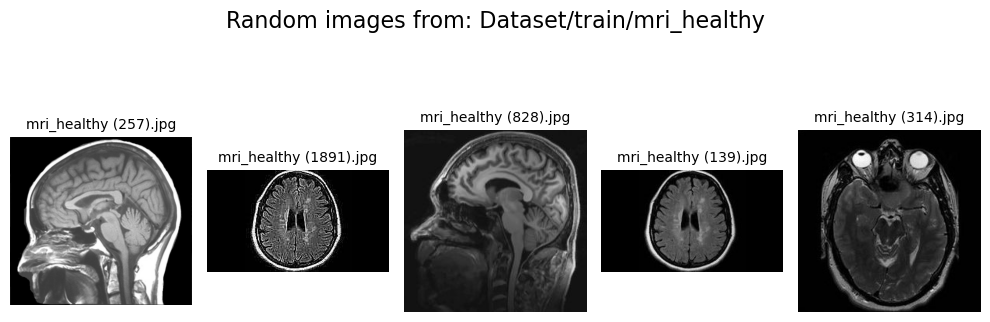

Folder: Dataset/train/mri_meningioma


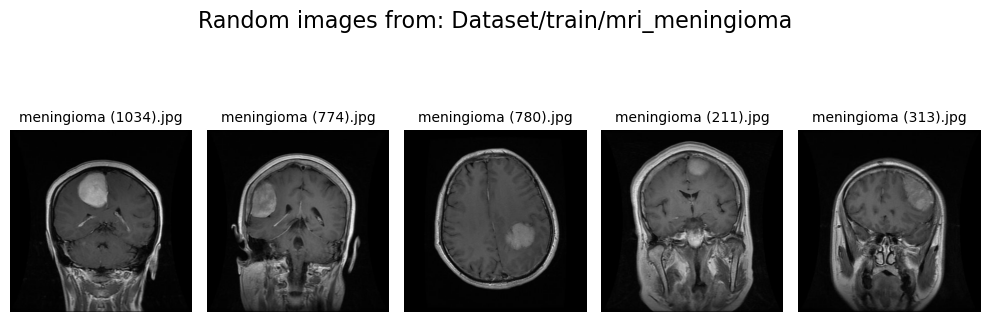

Folder: Dataset/train/mri_tumor


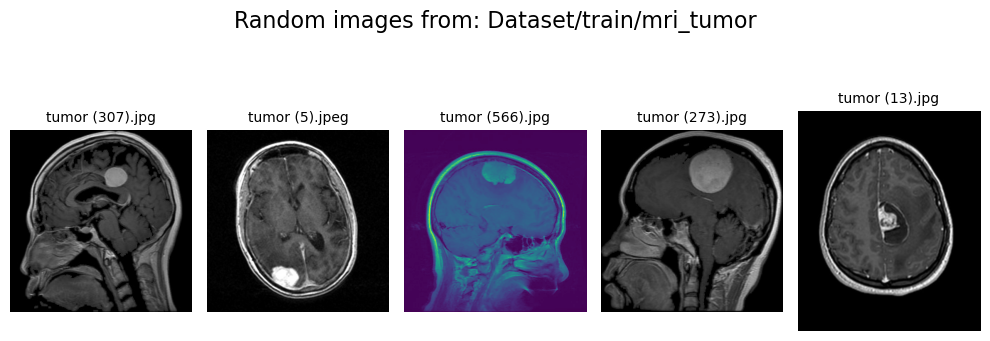

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Root directory of the dataset
root_dir = "Dataset/train"

# Number of random files to select per folder
num_samples = 5

# Dimensions to resize the images
resize_to = (250, 250)

# Traverse all folders
for root, dirs, files in os.walk(root_dir):
    if files:  # If the folder contains files
        full_paths = [os.path.join(root, f) for f in files]
        random_files = random.sample(full_paths, min(num_samples, len(full_paths)))
        print(f"Folder: {root}")
        
        # Create a plot with subplots
        fig, axes = plt.subplots(1, len(random_files), figsize=(10, 4))
        
        for ax, file in zip(axes, random_files):
            try:
                img = Image.open(file)
                # img = img.resize(resize_to)  # Resize the image
                ax.imshow(img)  # cmap="gray" is optional for grayscale images
                ax.set_title(os.path.basename(file), fontsize=10)
                ax.axis("off")  # Remove axes
            except Exception as e:
                print(f"Could not load image {file}: {e}")
        
        plt.suptitle(f"Random images from: {root}", fontsize=16)
        plt.tight_layout()
        plt.show()


There are some colored images, so let's examine their characteristics in detail, specifically the image mode of each file.

In [4]:
import os
from PIL import Image
from collections import defaultdict

# Main directory to traverse
directory = "Dataset"

# Use os.walk to traverse the directory and its subdirectories
for root, dirs, files in os.walk(directory):
    print(f"Current directory: {root}")
    
    # Dictionary to count image modes
    mode_count = defaultdict(int)
    
    # Count the modes of the images
    for file in files:
        full_path = os.path.join(root, file)
        try:
            with Image.open(full_path) as img:
                mode_count[img.mode] += 1  # Increment the counter for the mode
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Display the results for the current folder
    for mode, count in mode_count.items():
        print(f"Mode: {mode} | Count: {count}")
    
    print("-" * 40)


Current directory: Dataset
----------------------------------------
Current directory: Dataset/test
----------------------------------------
Current directory: Dataset/test/ct_tumor
Mode: RGB | Count: 338
Mode: L | Count: 10
----------------------------------------
Current directory: Dataset/test/mri_glioma
Mode: RGB | Count: 101
----------------------------------------
Current directory: Dataset/test/ct_healthy
Mode: L | Count: 59
Mode: RGB | Count: 285
Mode: RGBA | Count: 1
----------------------------------------
Current directory: Dataset/test/mri_pituitary
Mode: RGB | Count: 95
----------------------------------------
Current directory: Dataset/test/mri_healthy
Mode: L | Count: 37
Mode: RGB | Count: 262
Mode: RGBA | Count: 1
----------------------------------------
Current directory: Dataset/test/mri_meningioma
Mode: RGB | Count: 167
----------------------------------------
Current directory: Dataset/test/mri_tumor
Mode: RGB | Count: 79
Mode: L | Count: 10
------------------------

It also seems that some images have already been partialy augmented, as some of the images are rotated, as shown in this example:

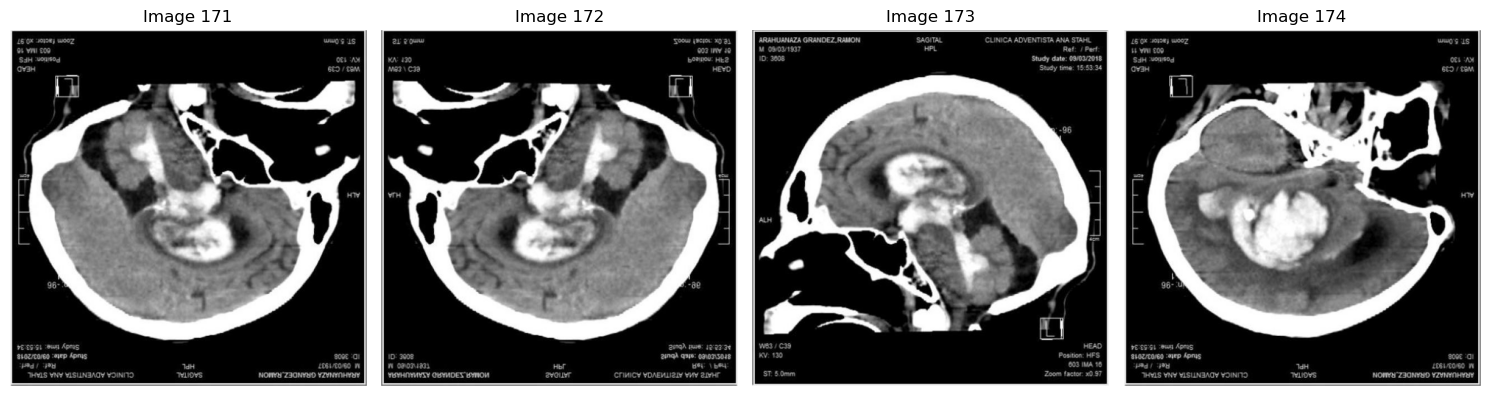

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the range of image numbers
start = 171
end = 174

# Directory and file pattern
directory = 'Dataset/train/ct_tumor/'
file_pattern = 'ct_tumor ({}).jpg'

# Load the images
images = [Image.open(f"{directory}{file_pattern.format(i)}") for i in range(start, end + 1)]

# Create a figure and axes for side-by-side display
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))  # 1 row, 7 columns

# Loop through the images and display them
for ax, img, num in zip(axes, images, range(start, end + 1)):
    ax.imshow(img)
    ax.axis('off')  # Hide axes for cleaner look
    ax.set_title(f"Image {num}")

# Show the plot
plt.tight_layout()
plt.show()


## EDA Findings

Starting from the most evident characteristics and delving deeper, we can conclude that the dataset includes:

- CT scan and MRI samples from both healthy patients and those with tumors.
- Samples from different sources, resulting in variations such as:
    - The inclusion of patient data within the image.
    - Different cuts and perspectives (frontal, top, lateral, etc.).
    - Images in different modes, specifically some in "L" mode (grayscale) and most in "RGB" mode (colored).
    - Images of varying sizes.
- Data augmentation has already been **partialy** applied, as there are cases where an image has been rotated and included in the dataset.

## EDA Conclusions and action Plan

Taking into account the previous findings and the number of images available in the dataset, we will leverage the transfer learning technique by using the Xception model from TensorFlow-Keras applications as a base, benefiting from its training on millions of images.

It is important to note that to use this model, we must adjust the input images to meet the specifications used during the training of the base model.

Action Plan:

1. Normalize Function:
    - Convert images to RGB if they are in grayscale (L) or RGBA.

2. Preprocessing:
    - Normalize the images to RGB and apply preprocess_input for compatibility with Xception.

3. ImageDataGenerator:
    - Use the preprocessing_function to seamlessly integrate normalization and preprocessing.

4. Load Data:
    - Load images from the designated folders.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, Precision, Recall


E0000 00:00:1736605172.191247   87545 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736605172.220981   87545 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Function to normalize images to RGB format
def normalize_image(image):
    if tf.shape(image)[-1] == 1:  # Grayscale mode (L)
        image = tf.image.grayscale_to_rgb(image)
    elif tf.shape(image)[-1] == 4:  # RGBA mode
        image = image[..., :3]  # Remove the alpha channel
    return image

# Combined function to normalize and preprocess
def custom_preprocessing(image):
    image = normalize_image(image)  # Ensure RGB format
    return preprocess_input(image)  # Preprocess for Xception

# Configure ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing)

In [5]:
# Load data

# Train
train_generator = datagen.flow_from_directory(
    'Dataset/train/',
    target_size=(299, 299),  # Expected size for Xception
    batch_size=32,
    class_mode='categorical'
)

# test
test_generator = datagen.flow_from_directory(
    'Dataset/test/',
    target_size=(299, 299),  # Expected size for Xception
    batch_size=32,
    class_mode='categorical'
)

# Validation
val_generator = datagen.flow_from_directory(
    'Dataset/test/',
    target_size=(299, 299),  # Expected size for Xception
    batch_size=32,
    class_mode='categorical'
)

Found 6730 images belonging to 7 classes.
Found 1445 images belonging to 7 classes.
Found 1445 images belonging to 7 classes.


In [11]:
train_generator.class_indices

{'ct_healthy': 0,
 'ct_tumor': 1,
 'mri_glioma': 2,
 'mri_healthy': 3,
 'mri_meningioma': 4,
 'mri_pituitary': 5,
 'mri_tumor': 6}

# Base model Prediction

Let's make a prediction with the base model as it is, just to see the results

First we need to load a single image and preprocess it as the required format expected by Xception model

In [6]:
from tensorflow.keras.preprocessing.image import load_img

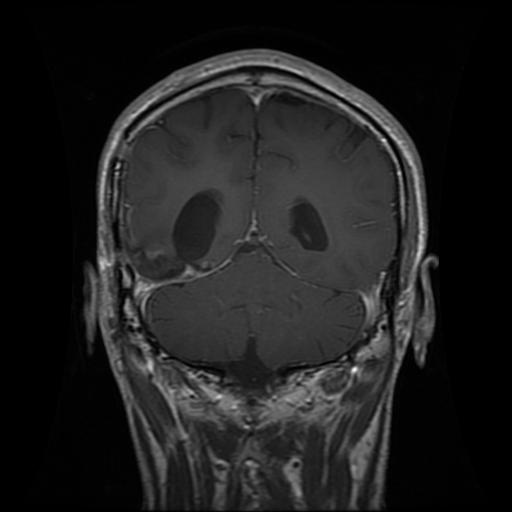

In [13]:
path = 'Dataset/train/mri_glioma'
name = 'glioma (453).jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [14]:
img = load_img(fullname, target_size=(299, 299))

Convert image to Array

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
x = np.array(img)
x.shape

(299, 299, 3)

Load model

In [17]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

I0000 00:00:1736535137.380130    3202 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Create a matrix instance (in this test is only 1 entity within the matrix)

In [18]:
X = np.array([x])

In [19]:
X.shape

(1, 299, 299, 3)

we have to adjust the image, in this case the mode is RGB so we dont need to transform its mode

In [20]:
X = preprocess_input(X)

In [21]:
pred = model.predict(X)

I0000 00:00:1736535148.798931    4182 service.cc:148] XLA service 0x7fcec8003910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736535148.813297    4182 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1736535149.183848    4182 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1736535154.205069    4182 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [22]:
decode_predictions(pred)

[[('n03124043', 'cowboy_boot', np.float32(0.071813054)),
  ('n03916031', 'perfume', np.float32(0.04237999)),
  ('n04192698', 'shield', np.float32(0.022686092)),
  ('n04487394', 'trombone', np.float32(0.022626625)),
  ('n02823750', 'beer_glass', np.float32(0.020067407))]]

We are getting unaccurate predictions, this is because the model was trained without this kind of images, so we'll proceed with transfer learning. And maybe we could make a test run with a model from scratch.

# Model Training

## Starting Point

I'll use the Xception architecture as the base model, taking advantage of its depthwise separable convolutions to extract detailed and efficient feature representations from the input images. Xception has consistently shown strong performance in image classification tasks and is well-suited for transfer learning due to its generalization capabilities and pretrained weights on the ImageNet dataset. (Also it has the best performance in the keras documentation, and was the one used on lesson 8 :D )

The base model will be adapted for our specific classification task by removing its top layers and adding custom ones. First, I will use a GlobalAveragePooling2D layer to reduce the spatial dimensions of the feature maps and extract a compact representation of the features. Next, I’ll include a Dense layer with 256 units and ReLU activation to allow the model to learn patterns specific to our dataset. Finally, a Dense layer with 7 units and softmax activation will output the probabilities for the 7 classes in our dataset.

In [8]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [23]:


# Load Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze base model for initial training
base_model.trainable = False

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax')
])

metrics = [
    'accuracy',
    AUC(name='roc_auc'),
    Precision(name='precision'),
    Recall(name='recall')
]

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)


In [24]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


E0000 00:00:1736535297.221603    4179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535297.366973    4179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535300.251564    4179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535300.459532    4179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535300.664386    4179 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

201/211 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.7215 - loss: 0.7397 - precision: 0.8414 - recall: 0.6112 - roc_auc: 0.9469

E0000 00:00:1736535383.275397    4182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535383.408856    4182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535383.559423    4182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535383.766050    4182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535383.852140    4182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7251 - loss: 0.7302 - precision: 0.8426 - recall: 0.6170 - roc_auc: 0.9482

E0000 00:00:1736535414.432112    4180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535414.569870    4180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535414.715472    4180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535414.858273    4180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736535415.062345    4180 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

211/211 ━━━━━━━━━━━━━━━━━━━━ 137s 535ms/step - accuracy: 0.7254 - loss: 0.7293 - precision: 0.8427 - recall: 0.6175 - roc_auc: 0.9483 - val_accuracy: 0.8651 - val_loss: 0.3609 - val_precision: 0.8932 - val_recall: 0.8394 - val_roc_auc: 0.9882
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 91s 432ms/step - accuracy: 0.8801 - loss: 0.3204 - precision: 0.9051 - recall: 0.8558 - roc_auc: 0.9906 - val_accuracy: 0.8879 - val_loss: 0.3060 - val_precision: 0.8994 - val_recall: 0.8720 - val_roc_auc: 0.9915
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 90s 429ms/step - accuracy: 0.9018 - loss: 0.2720 - precision: 0.9200 - recall: 0.8800 - roc_auc: 0.9929 - val_accuracy: 0.8927 - val_loss: 0.2921 - val_precision: 0.8994 - val_recall: 0.8789 - val_roc_auc: 0.9922
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 87s 413ms/step - accuracy: 0.9226 - loss: 0.2118 - precision: 0.9342 - recall: 0.9101 - roc_auc: 0.9955 - val_accuracy: 0.9038 - val_loss: 0.2660 - val_precision: 0.9104 - val_recall: 0.8927 - val_roc_auc: 0.992

Let's take a look at the accuracy to see the performance at a glance.

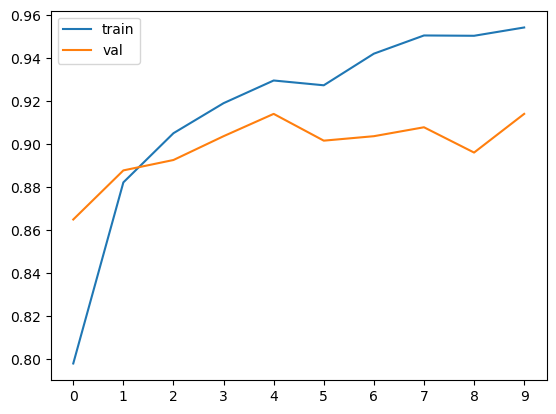

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

It seems the model is working fine, showing that it's not overfitting with a high accuuracy (greater than 90%), so let's see how precise are its predictions by checking recall and roc_auc

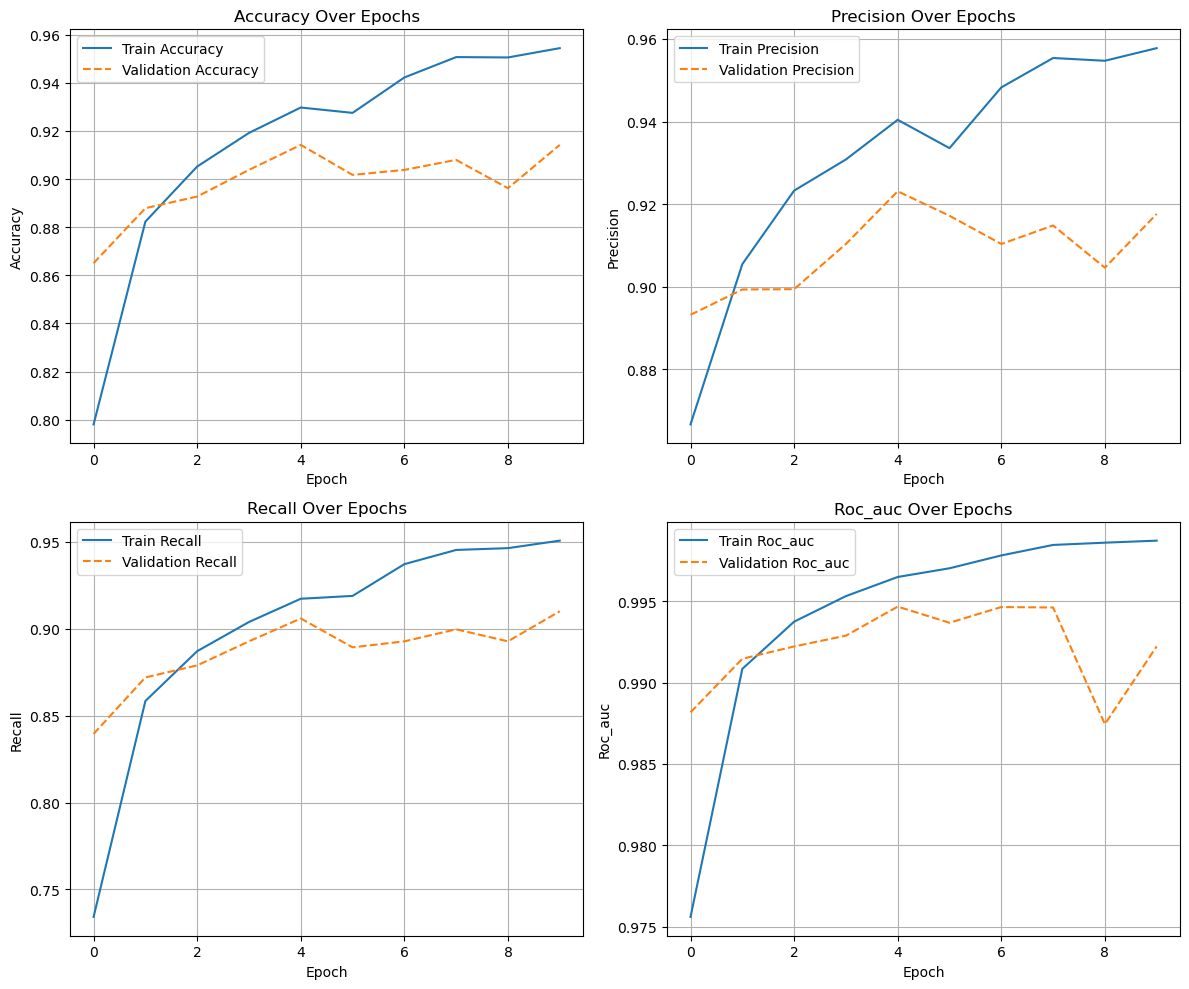

In [27]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall', 'roc_auc']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  

for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(history.history[metric], label=f'Train {metric.capitalize()}')
    ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', linestyle='dashed')
    
    ax.set_title(f"{metric.capitalize()} Over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


As stated before, the main metric for this project will be recall, as we have to be very precise when stating that a patient has a tumor, an in this case, there are some epochs with recall greater than 90%. This is good, let's try a single prediction with this model

In [28]:
pred_one = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [29]:
pred_one.round(3)

array([[0.   , 0.   , 0.888, 0.   , 0.084, 0.   , 0.027]], dtype=float32)

In [30]:
classes = [
    'ct_healthy',
    'ct_tumor',
    'mri_glioma',
    'mri_healthy',
    'mri_meningioma',
    'mri_pituitary',
    'mri_tumor'
]

In [31]:
dict(zip(classes, pred_one[0].round(3)))

{'ct_healthy': np.float32(0.0),
 'ct_tumor': np.float32(0.0),
 'mri_glioma': np.float32(0.888),
 'mri_healthy': np.float32(0.0),
 'mri_meningioma': np.float32(0.084),
 'mri_pituitary': np.float32(0.0),
 'mri_tumor': np.float32(0.027)}

Theres a huge difference compared to the prediction made before training, in this recent attempt, the model identifies the image as mri_glioma with 'mri_glioma': np.float32(0.925),

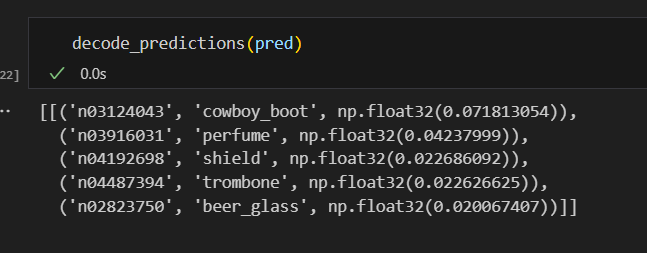

Also, lets try with the test dataset

In [35]:
model.evaluate(test_generator)



46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.9168 - loss: 0.2754 - precision: 0.9188 - recall: 0.9107 - roc_auc: 0.9902


[0.2601143419742584,
 0.9141868352890015,
 0.9922283887863159,
 0.9176552891731262,
 0.9100345969200134]

## Hyperparameter tuning 

As brain cancer detection is a very sensitive use case, our target should always be to achieve the most accurate and reliable predictions. To enhance the model's performance, I will experiment with variations of the following parameters:

- Learning Rate: Adjusting the learning rate to find the optimal balance between convergence speed and model stability.
- Additional Layers and Layer Size Variation: Adding or modifying layers in the network architecture, as well as experimenting with different layer sizes, to optimize feature extraction and model complexity.
- Dropout Rates: Modifying dropout rates to prevent overfitting and improve model generalization.
- Data Augmentation: Applying techniques like rotation, flipping, and zoom to enhance the diversity of the training dataset and improve model robustness.


### Learning Rate

In [9]:
from tensorflow import keras

In [37]:
def make_model(learning_rate=0.01):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(7, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    metrics = [
    'accuracy',
    AUC(name='roc_auc'),
    Precision(name='precision'),
    Recall(name='recall')
    
    ]
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    return model

In [38]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 105s 467ms/step - accuracy: 0.6398 - loss: 1.1568 - precision: 0.8570 - recall: 0.3164 - roc_auc: 0.8886 - val_accuracy: 0.8318 - val_loss: 0.5348 - val_precision: 0.9134 - val_recall: 0.7225 - val_roc_auc: 0.9796
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 87s 410ms/step - accuracy: 0.8413 - loss: 0.5158 - precision: 0.9047 - recall: 0.7286 - roc_auc: 0.9810 - val_accuracy: 0.8498 - val_loss: 0.4389 - val_precision: 0.9115 - val_recall: 0.7841 - val_roc_auc: 0.9846
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 87s 411ms/step - accuracy: 0.8564 - loss: 0.4196 - precision: 0.9003 - recall: 0.7908 - roc_auc: 0.9866 - val_accuracy: 0.8824 - val_loss: 0.3732 - val_precision: 0.9140 - val_recall: 0.8311 - val_roc_auc: 0.9898
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 87s 415ms/step - accuracy: 0.8789 - loss: 0.3544 - precision: 0.9194 - recall: 0.8317 - roc_auc: 0.9905 - val_accuracy: 0.8865 - val_loss: 0.3441 - val_precision: 0.9142 - val_recall: 0.8484 - 

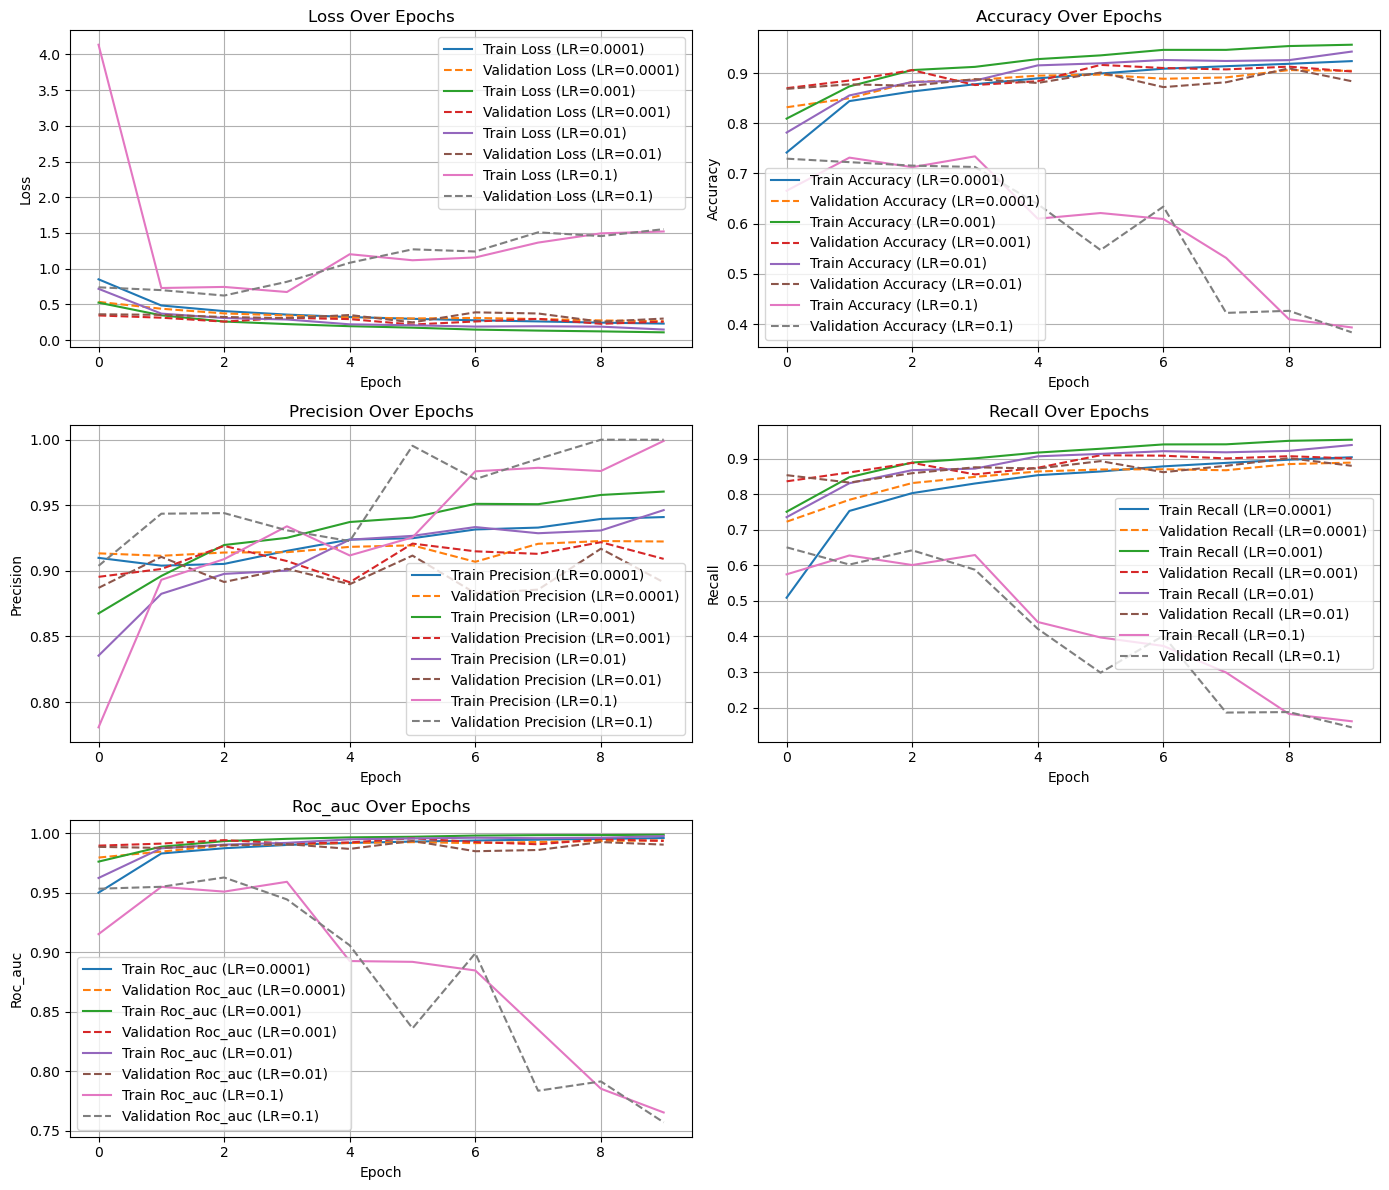

In [43]:
import matplotlib.pyplot as plt

metrics = ['loss', 'accuracy', 'precision', 'recall', 'roc_auc']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))  

axes = axes.flatten()

for metric, ax in zip(metrics, axes):
    for lr, history in scores.items():
        ax.plot(history[metric], label=f'Train {metric.capitalize()} (LR={lr})')
        ax.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()} (LR={lr})', linestyle='dashed')
    
    ax.set_title(f"{metric.capitalize()} Over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


The performance of 0.1 learning rate is the worst 0.1, so let's discard it and graph to see more detail

In [44]:
del scores[0.1]

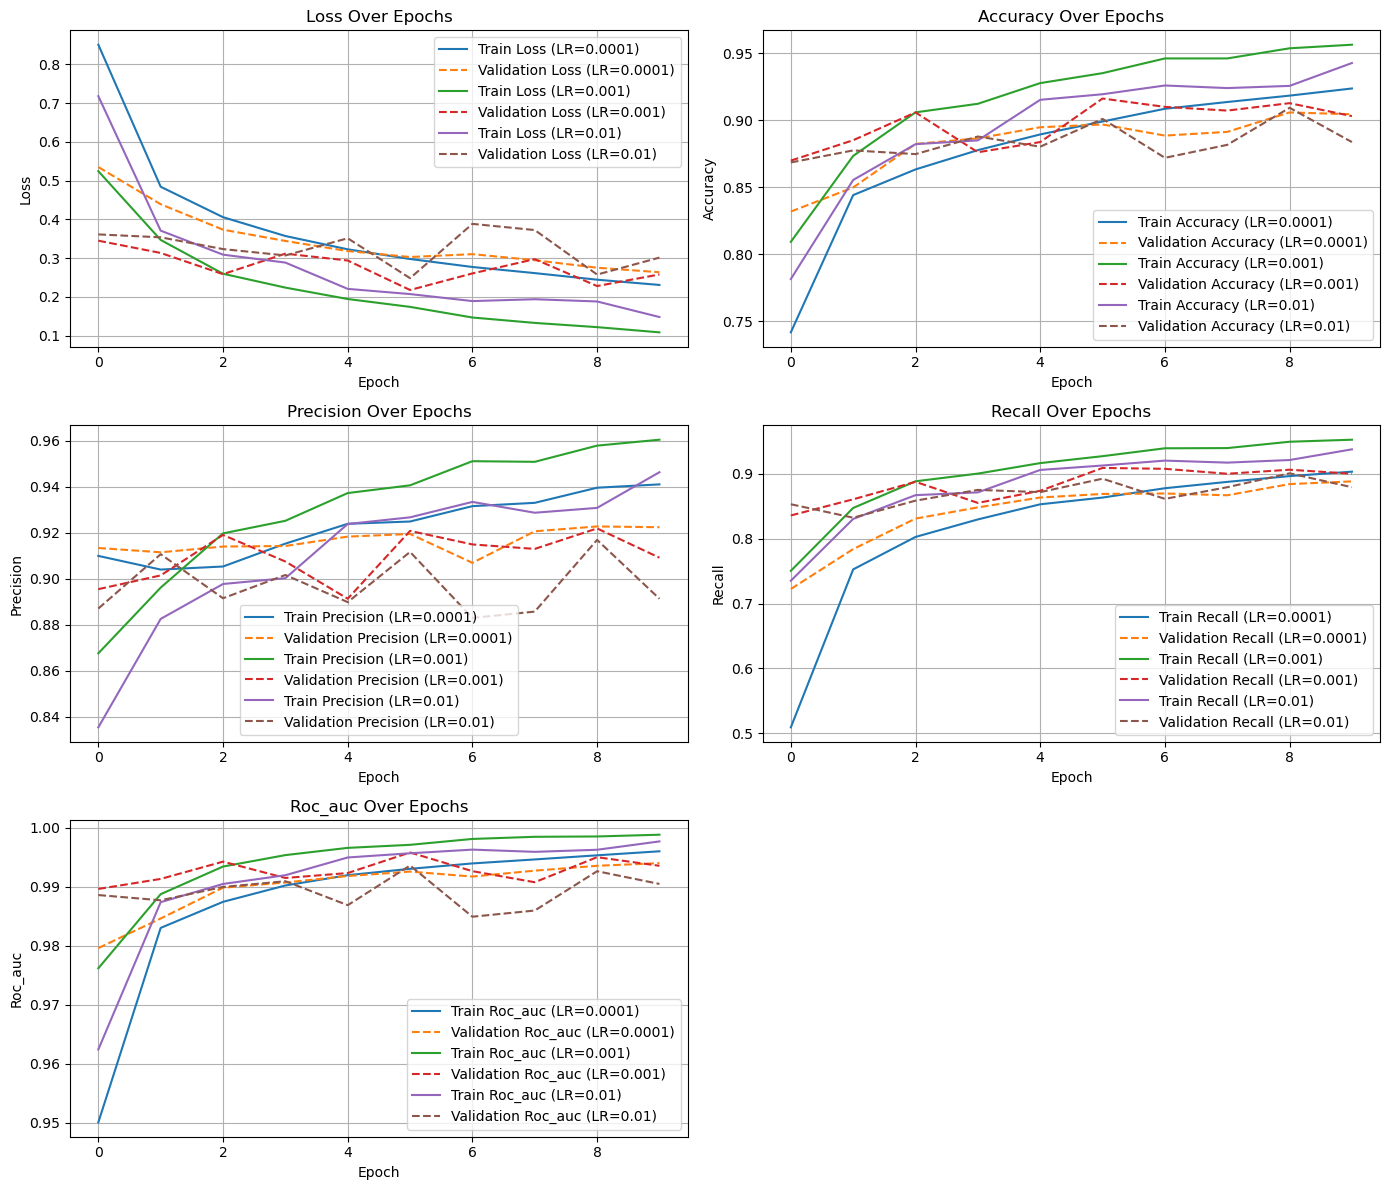

In [47]:
import matplotlib.pyplot as plt

metrics = ['loss', 'accuracy', 'precision', 'recall', 'roc_auc']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))  

axes = axes.flatten()

for metric, ax in zip(metrics, axes):
    for lr, history in scores.items():
        ax.plot(history[metric], label=f'Train {metric.capitalize()} (LR={lr})')
        ax.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()} (LR={lr})', linestyle='dashed')
    
    ax.set_title(f"{metric.capitalize()} Over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


As we can see in the Recall graph and the validation dotted lines, the best option is the 0.001 learning rate

Best parameters:

- Learning rate = 0.001

From this point on, I'll activate the checkpoint flag in order to save the best model achieved

### Additional Layer

Adding an inner layer and testing different sizes

In [49]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(size_inner, activation='relu'),
        Dense(7, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    metrics = [
    'accuracy',
    AUC(name='roc_auc'),
    Precision(name='precision'),
    Recall(name='recall')
    ]
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    return model

In [10]:
import time

In [51]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v_metrics1_{epoch:02d}_{val_accuracy:.3f}.weights.h5.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [52]:
%%time
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator,callbacks=[checkpoint])
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 117s 516ms/step - accuracy: 0.6429 - loss: 1.0594 - precision: 0.8587 - recall: 0.4462 - roc_auc: 0.8914 - val_accuracy: 0.8547 - val_loss: 0.4261 - val_precision: 0.9074 - val_recall: 0.8138 - val_roc_auc: 0.9846
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 93s 440ms/step - accuracy: 0.8553 - loss: 0.4141 - precision: 0.8836 - recall: 0.8131 - roc_auc: 0.9849 - val_accuracy: 0.8782 - val_loss: 0.3407 - val_precision: 0.9064 - val_recall: 0.8581 - val_roc_auc: 0.9898
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 91s 429ms/step - accuracy: 0.8894 - loss: 0.3053 - precision: 0.9082 - recall: 0.8649 - roc_auc: 0.9917 - val_accuracy: 0.8796 - val_loss: 0.3234 - val_precision: 0.9002 - val_recall: 0.8616 - val_roc_auc: 0.9907
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 87s 414ms/step - accuracy: 0.8988 - loss: 0.2630 - precision: 0.9139 - recall: 0.8807 - roc_auc: 0.9937 - val_accuracy: 0.8810 - val_loss: 0.2930 - val_precision: 0.8956 - val_recall: 0.8671 - val_

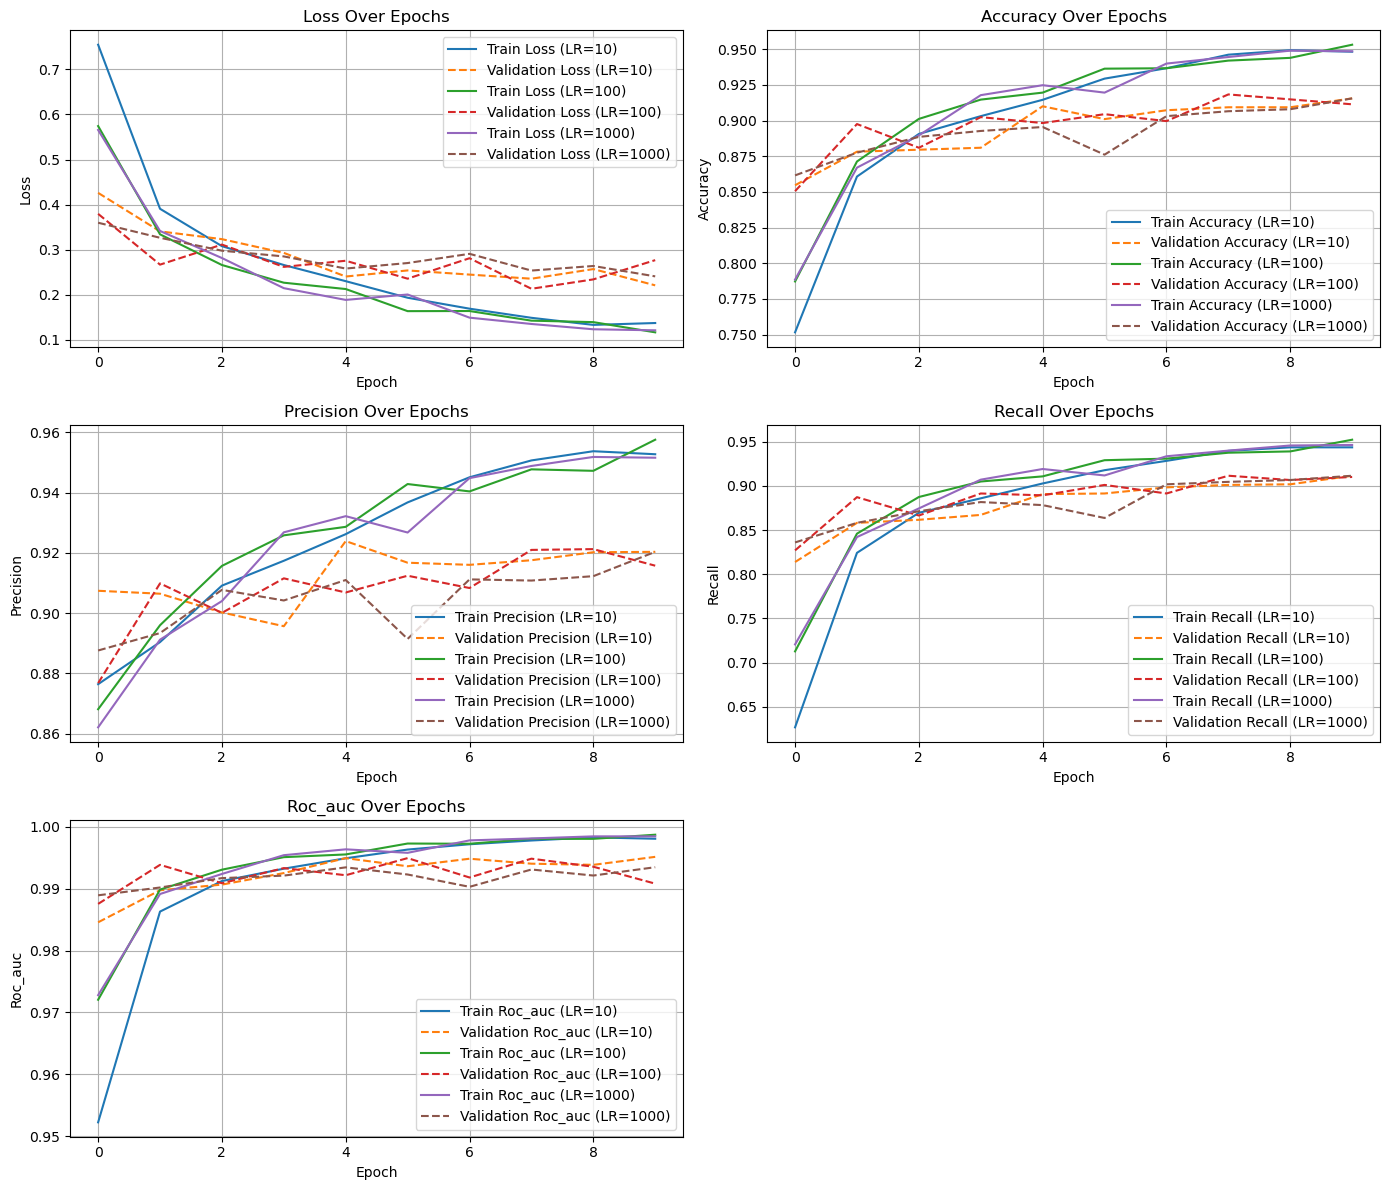

In [56]:
import matplotlib.pyplot as plt

metrics = ['loss', 'accuracy', 'precision', 'recall', 'roc_auc']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))  

axes = axes.flatten()

for metric, ax in zip(metrics, axes):
    for lr, history in scores.items():
        ax.plot(history[metric], label=f'Train {metric.capitalize()} (LR={lr})')
        ax.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()} (LR={lr})', linestyle='dashed')
    
    ax.set_title(f"{metric.capitalize()} Over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


The best performance is achieved with an additional layer of size 100, as it demonstrates more stable and accurate results. Although the model with size 1000 reached a performance peak at epoch #7, I will choose size 100, prioritizing stability.

Best parameters:

- Learning rate = 0.001
- Inner Dense Layer size = 100

### Dropout

Now, I will explore the model by applying the dropout technique, which, in theory, will help mitigate potential overfitting effects. Additionally, in this test, I will increase the number of epochs to 20, as it is expected that the model will learn more slowly due to the missing information introduced by dropout at each iteration.


In [11]:
from tensorflow.keras.layers import Dropout

In [68]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v2_recall_{epoch:02d}_{val_recall:.3f}.weights.h5.keras',
    save_best_only=True,
    monitor='val_recall',
    mode='max'
)

In [66]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(size_inner, activation='relu'),
        Dropout(droprate), 
        Dense(7, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    metrics = [
    'accuracy',
    AUC(name='roc_auc'),
    Precision(name='precision'),
    Recall(name='recall')
    ]
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    return model

In [60]:
%%time
learning_rate = 0.001
size_inner = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size_inner,
        droprate=droprate
    )
    history = model.fit(train_generator, epochs=20, validation_data=val_generator,callbacks=[checkpoint])
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 118s 492ms/step - accuracy: 0.7197 - loss: 0.7669 - precision: 0.8371 - recall: 0.5968 - roc_auc: 0.9413 - val_accuracy: 0.8429 - val_loss: 0.4156 - val_precision: 0.8819 - val_recall: 0.8014 - val_roc_auc: 0.9844
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 94s 443ms/step - accuracy: 0.8702 - loss: 0.3638 - precision: 0.8936 - recall: 0.8391 - roc_auc: 0.9881 - val_accuracy: 0.8920 - val_loss: 0.2874 - val_precision: 0.9034 - val_recall: 0.8734 - val_roc_auc: 0.9926
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 91s 430ms/step - accuracy: 0.9024 - loss: 0.2655 - precision: 0.9190 - recall: 0.8860 - roc_auc: 0.9933 - val_accuracy: 0.8997 - val_loss: 0.2689 - val_precision: 0.9136 - val_recall: 0.8851 - val_roc_auc: 0.9934
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 90s 427ms/step - accuracy: 0.9183 - loss: 0.2140 - precision: 0.9311 - recall: 0.9080 - roc_auc: 0.9957 - val_accuracy: 0.8969 - val_loss: 0.2599 - val_precision: 0.9061 - val_recall: 0.8879 - val

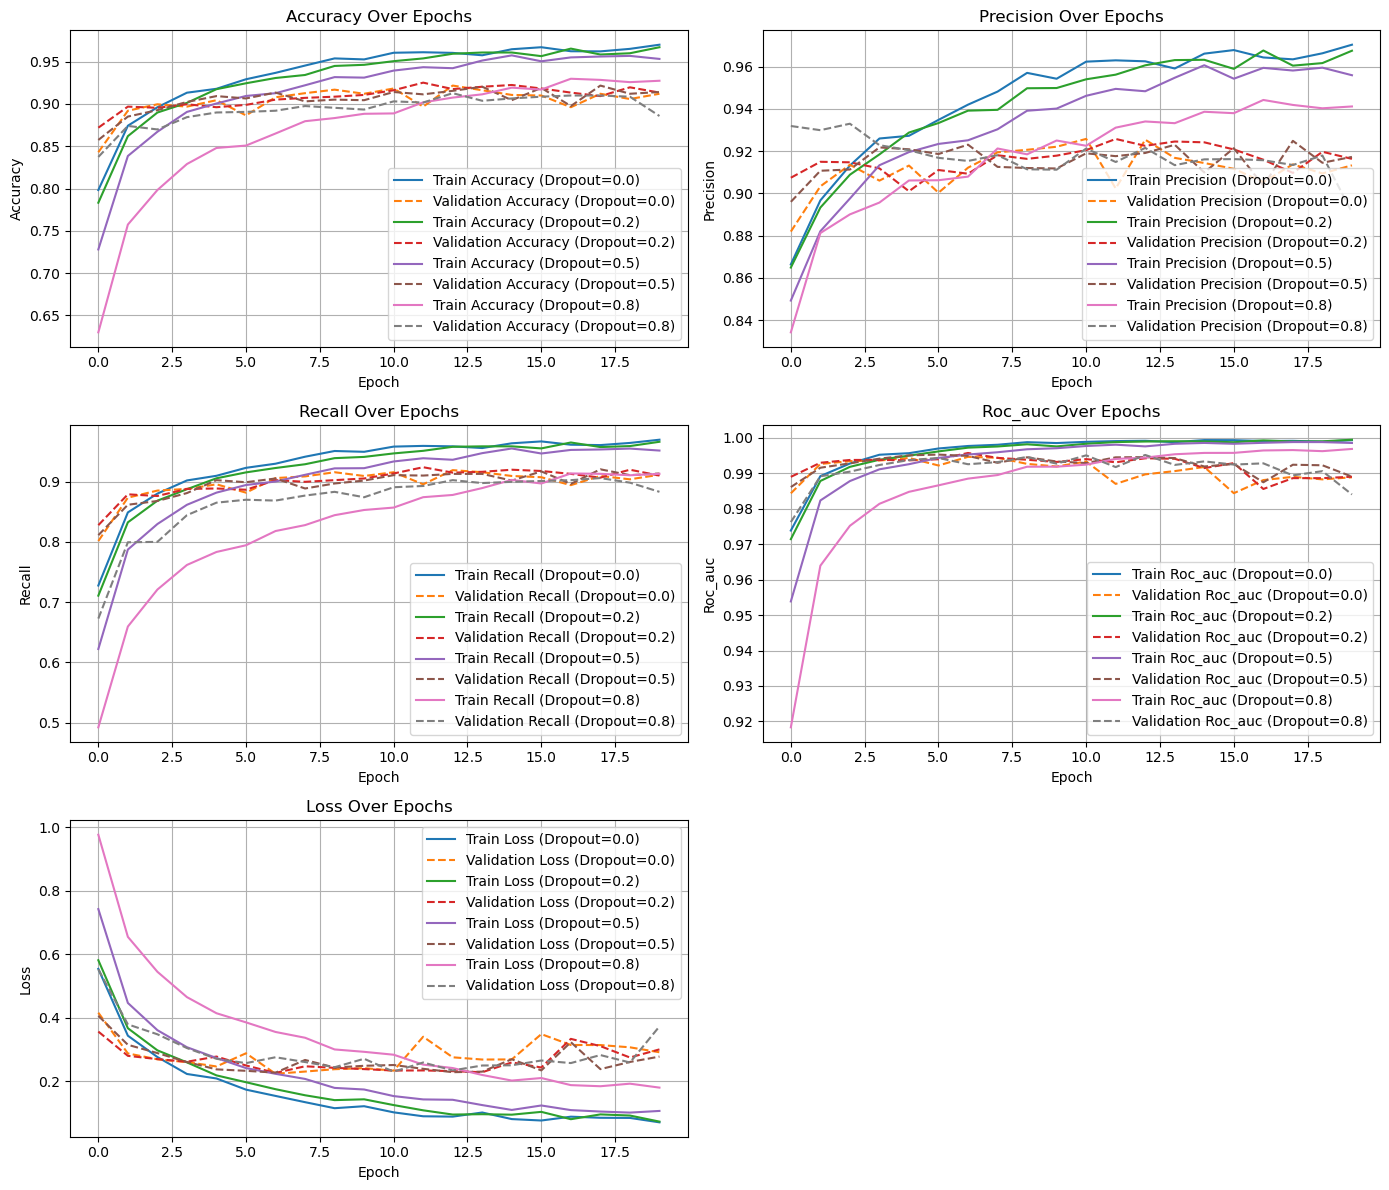

In [63]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'loss']

fig, axes = plt.subplots(3, 2, figsize=(14, 12))  

axes = axes.flatten()

for metric, ax in zip(metrics, axes):
    for droprate, history in scores.items():  
        ax.plot(history[metric], label=f'Train {metric.capitalize()} (Dropout={droprate})')
        ax.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()} (Dropout={droprate})', linestyle='dashed')
    
    ax.set_title(f"{metric.capitalize()} Over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


At this point, we observe an interesting behavior: the model's performance starts to degrade after 10 epochs. This degradation is subtly noticeable in the accuracy, precision, and recall metrics but becomes much more evident in the ROC-AUC metric and even more so in the loss measurement.

On the other hand, the best recall is achieved with a dropout rate of 0.2, so we will maintain this configuration as the best option for the model at this stage.

Best parameters:

- Learning rate = 0.001
- Inner Dense Layer size = 100
- Dropout Rate = 0.2

### Data Augmentation

Now I'll try some data augmentation. I just have to take into account that there are some images in the dataset that had already been augmented.

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_recall:.3f}.weights.h5.keras',
    save_best_only=True,
    monitor='val_recall', # ajustar a recall
    mode='max'
)

In [13]:
def load_images(parameter):
    datagen = ImageDataGenerator(**parameter)
    train_generator = datagen.flow_from_directory(
        'Dataset/train/',
        target_size=(299, 299),  # Expected size for Xception
        batch_size=32,
        class_mode='categorical',
    )
    return train_generator

In [14]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(size_inner, activation='relu'),
        Dropout(droprate), 
        Dense(7, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    metrics = [
    'accuracy',
    AUC(name='roc_auc'),
    Precision(name='precision'),
    Recall(name='recall')
    ]

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    return model

In [ ]:
%%time
learning_rate = 0.001
size_inner = 100
droprate=0.2

scores = {}

parameters1 = [
    {"rotation_range": 20},
    {"width_shift_range": 0.2},
    {"height_shift_range": 0.2}
]

parameters2 = [
    {"shear_range": 0.2},
    {"zoom_range": 0.2},
    {"horizontal_flip": True}
]

for p_ in parameters1:
    print(p_)

    train_generator = load_images(p_)

    model = make_model(learning_rate=learning_rate,size_inner=size_inner,droprate=droprate)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator,callbacks=[checkpoint])

    scores[str(p_)] = history.history

    print()
    print()

for p_ in parameters2:
    print(p_)

    train_generator = load_images(p_)

    model = make_model(learning_rate=learning_rate,size_inner=size_inner,droprate=droprate)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator,callbacks=[checkpoint])

    scores[str(p_)] = history.history

    print()
    print()

{'rotation_range': 20}
Found 6730 images belonging to 7 classes.


I0000 00:00:1736605343.271622   87545 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10


I0000 00:00:1736605348.857248   89033 service.cc:148] XLA service 0x7fd7b0003d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736605348.857708   89033 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1736605349.983407   89033 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1736605362.602041   89033 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736605362.747027   89033 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736605362.898445   89033 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1

  1/211 ━━━━━━━━━━━━━━━━━━━━ 1:34:06 27s/step - accuracy: 0.2500 - loss: 3.5218 - precision: 0.2083 - recall: 0.1562 - roc_auc: 0.6060

I0000 00:00:1736605371.902506   89033 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 40/211 ━━━━━━━━━━━━━━━━━━━━ 1:11 418ms/step - accuracy: 0.3863 - loss: 2.5878 - precision: 0.4494 - recall: 0.3191 - roc_auc: 0.7476

E0000 00:00:1736605394.964718   89033 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736605395.110113   89033 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736605395.251759   89033 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.5420 - loss: 1.5254 - precision: 0.6351 - recall: 0.4441 - roc_auc: 0.8590

E0000 00:00:1736605488.889499   89034 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736605489.086890   89034 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


211/211 ━━━━━━━━━━━━━━━━━━━━ 148s 575ms/step - accuracy: 0.5424 - loss: 1.5232 - precision: 0.6356 - recall: 0.4445 - roc_auc: 0.8592 - val_accuracy: 0.1965 - val_loss: 1.9606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5956
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 99s 468ms/step - accuracy: 0.7241 - loss: 0.7383 - precision: 0.7969 - recall: 0.6467 - roc_auc: 0.9540 - val_accuracy: 0.2367 - val_loss: 1.9960 - val_precision: 0.1124 - val_recall: 0.0069 - val_roc_auc: 0.5837
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 97s 459ms/step - accuracy: 0.7643 - loss: 0.6313 - precision: 0.8159 - recall: 0.6975 - roc_auc: 0.9661 - val_accuracy: 0.1869 - val_loss: 2.1502 - val_precision: 0.1108 - val_recall: 0.0298 - val_roc_auc: 0.5787
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 98s 470ms/step - accuracy: 0.7882 - loss: 0.5648 - precision: 0.8361 - recall: 0.7373 - roc_auc: 0.9720 - val_accuracy: 0.1979 - val_loss: 2.1739 - val_precision: 0.0421 - val_recall: 0.0111 - val_roc_au

Note: I have conducted several tests at this point, even running the model for 50 epochs. However, in every case, this technique caused the model's performance to worsen. For illustrative purposes, I ran the test for only 10 epochs in this notebook.

# Final Settings

Best parameters:

- Learning rate = 0.001
- Inner Dense Layer size = 100
- Dropout Rate = 0.2
- Data Augmentation = None